**Jax for constitutive laws**

Pierre Kerfriden, Mines Paris - PSL

# Constitutive Newton Solver — Code Overview (Colab-friendly)

This document explains how the provided JAX code works. All math is in LaTeX between `$$`, so you can paste this into a Colab/Markdown cell directly.

---

## 1) Problem setting (small-strain, 6-component Voigt)

Strain and stress live in Voigt form with 6 components:
$$
\varepsilon,\ \sigma \in \mathbb{R}^6
$$

We use a diagonal shear weighting in the Voigt norm:
$$
W=\mathrm{diag}(1,1,1,2,2,2),\qquad
\|v\|_W=\sqrt{v^\top W\,v}.
$$

The volumetric projector and deviatoric projector are
$$
I_\mathrm{vol}=(1,1,1,0,0,0)^\top,\qquad
P_\mathrm{dev}=I-\tfrac13 I_\mathrm{vol}\,I_\mathrm{vol}^\top.
$$

---

## 2) Isotropic linear elasticity (6×6 stiffness)

The function `C_iso_voigt(E,nu)` returns the standard isotropic stiffness matrix in Voigt notation:
$$
\mu=\frac{E}{2(1+\nu)},\quad
\lambda=\frac{E\,\nu}{(1+\nu)(1-2\nu)},\quad
\lambda_2=\lambda+2\mu.
$$

In matrix form (non-zero blocks):
$$
\mathbf{C}=\begin{bmatrix}
\lambda_2 & \lambda & \lambda \\
\lambda & \lambda_2 & \lambda \\
\lambda & \lambda & \lambda_2
\end{bmatrix}
\oplus
\mu I_{3\times 3}.
$$

Hooke’s law (elastic relation) in Voigt form:
$$
\sigma = \mathbf{C}\,(\varepsilon-\varepsilon^p).
$$

---

## 3) Yield function and helpers

Deviatoric stress and its weighted norm:
$$
s=P_\mathrm{dev}\,\sigma,\qquad
\|s\|_W=\sqrt{s^\top W s}.
$$

An isotropic hardening law (exponential saturation) is used:
$$
R(p)=Q\big(1-e^{-b\,p}\big),
$$
and the J2 yield function is
$$
f(\sigma,p)=\sqrt{\tfrac{3}{2}}\ \|s\|_W \;-\; \big(\sigma_y+R(p)\big).
$$

---

## 4) Unknown vector for Newton

For the basic J2 case, the Newton unknown vector is
$$
x=\begin{bmatrix}
\sigma \\ \varepsilon^p \\ p \\ \gamma
\end{bmatrix}
\in \mathbb{R}^{6+6+1+1},
$$
where \(p\) is the equivalent plastic strain and \(\gamma\) is the plastic multiplier increment.

The state carried across time steps is
$$
\text{state}=\begin{bmatrix}\varepsilon^p \\ p\end{bmatrix}\in\mathbb{R}^{6+1}.
$$

(Your extended variants can append extra internal variables like kinematic backstress, but this base description sticks to the shown code.)

---

## 5) Residual vector (associated plasticity)

The residuals implement four blocks:

1) **Elastic relation**  
   $$ r_\sigma = \sigma - \mathbf{C}\,(\varepsilon-\varepsilon^p). $$

2) **Associated flow rule** (no unit normalization; truly \( \partial f/\partial\sigma \))  
   $$ \Delta\varepsilon^p = \gamma\,\frac{\partial f}{\partial \sigma}. $$
   Discretized as a residual:
   $$
   r_{\varepsilon^p} = \big(\varepsilon^p-\varepsilon^p_\text{old}\big) - \gamma\;\frac{\partial f}{\partial \sigma}.
   $$

3) **Equivalent plastic strain**  
   With this convention, \( \Delta p = \gamma \):
   $$
   r_p = (p-p_\text{old})-\gamma.
   $$

4) **Consistency/elastic switch**  
   If the predictor is elastic (trial \(f\le 0\)), enforce \(\gamma=0\).  
   If plastic, enforce \(f(\sigma,p)=0\). Implemented lazily (no derivative leakage):
   $$
   r_\gamma =
   \begin{cases}
   f(\sigma,p), & \text{if } f_\text{trial}>0\\[4pt]
   \gamma, & \text{else.}
   \end{cases}
   $$

The full residual is the concatenation:
$$
r(x)=\begin{bmatrix}
r_\sigma \\ r_{\varepsilon^p} \\ r_p \\ r_\gamma
\end{bmatrix}.
$$

**Notes on derivatives.**  
The associated gradient is obtained by automatic differentiation:
$$
\frac{\partial f}{\partial \sigma}
=\mathrm{grad}_\sigma\left(\sqrt{\tfrac{3}{2}}\|P_\mathrm{dev}\,\sigma\|_W - (\sigma_y+R(p))\right),
$$
and is evaluated **only on the plastic branch** to avoid undefined behavior at \(s=0\).

---

## 6) Trial state & plasticity switch

The elastic predictor uses the *old* plastic strain:
$$
\sigma_\text{trial}=\mathbf{C}\,(\varepsilon-\varepsilon^p_\text{old}),\qquad
f_\text{trial}=f(\sigma_\text{trial},p_\text{old}).
$$

- If \(f_\text{trial}\le 0\): elastic step, \(\gamma=0\) and the trial state is already consistent, giving zero residual.
- If \(f_\text{trial}>0\): plastic step, run Newton on \(r(x)=0\).

The code evaluates the plastic branch lazily with `lax.cond`, preventing the inactive branch from polluting the Jacobian.

---

## 7) Newton–Raphson solver

We solve \( r(x)=0 \) with a standard Newton loop:

- Residual and Jacobian:
  $$
  r = r(x),\qquad J = \frac{\partial r}{\partial x}(x)\ \ (\text{via } \texttt{jacfwd}).
  $$
- Linear solve and update:
  $$
  J\,\Delta x = r,\qquad x \leftarrow x - \Delta x.
  $$
- Stopping:
  $$
  \|r\|\ <\ \text{abs\_tol}\quad\text{or}\quad \|r\|\ <\ \text{tol}\,\|r(x_0)\|.
  $$

The implementation:

- Builds `res(x)` as a closure over `residual_fn(x, *dyn_args)`.
- Prebuilds `Jfun = jacfwd(res)` once per Newton call.
- Uses `lax.while_loop` to run up to `max_iter` steps.
- Returns \((x_\text{fin}, \text{iters})\) with `iters=-1` if the test never passed.

---

## 8) Initialization and post-processing

**Initialization (`initialize_newton`)**
- Takes the current total strain \(\varepsilon\), prior state \((\varepsilon^p_\text{old}, p_\text{old})\), and builds
  $$
  \sigma_\text{trial}=\mathbf{C}\,(\varepsilon-\varepsilon^p_\text{old}),
  $$
  then sets
  $$
  x_0 = \begin{bmatrix}\sigma_\text{trial} \\ \varepsilon^p_\text{old} \\ p_\text{old} \\ 0\end{bmatrix}.
  $$

**Post-processing (`stress_and_state_from_newton`)**
- Unpacks \(x\) into \((\sigma, \varepsilon^p, p, \gamma)\) and returns:
  $$
  \text{state}_\text{new}=\begin{bmatrix}\varepsilon^p \\ p\end{bmatrix},\qquad \sigma.
  $$

---

## 9) Model abstraction (swap laws easily)

A small `Model` bundles the three law-specific callables:
$$
\text{Model}=\{\ \text{residuals},\ \text{initialize\_newton},\ \text{stress\_and\_state\_from\_newton}\ \}.
$$

You pass the `Model` as a **static** argument to the jitted driver so changing any of the three functions triggers retracing with the new law.

---

## 10) Time stepping with `lax.scan`

Given a strain history \(\{\varepsilon_t\}_{t=0}^{T-1}\), the driver:

1) Carries the state \(s_t\).
2) For each time \(t\), calls
   $$
   (s_{t+1},\ \sigma_t,\ \text{iters}_t) = \text{constitutive\_update}(\varepsilon_t, s_t, \text{params}),
   $$
   where `constitutive_update` does `initialize → Newton → postprocess`.
3) `lax.scan` returns the final state and the stacked outputs over time.

`simulate` is jitted with the `model` marked static:
- **Static**: `model` (contains functions).
- **Dynamic**: `epsilon_ts`, `state0`, `params` (so you can sweep values without recompiling).

---

## 11) JAX/JIT tips used here

- Only **function objects** (the model’s callables) are `static`. Arrays (`epsilon_ts`, `state`, `params`) are **dynamic**.
- Branches that would cause invalid algebra (e.g., normalizing at \(s=0\)) are made **lazy** with `lax.cond` to avoid evaluating the inactive branch and corrupting the Jacobian.
- The Newton tolerances are **dynamic scalars** cast to the device dtype of \(x\).

---

## 12) Shapes at a glance (base J2)

- Unknown \(x\): \(6\ \sigma + 6\ \varepsilon^p + 1\ p + 1\ \gamma = 14\).
- Residual \(r(x)\): same length \(14\).
- State: \(6\ \varepsilon^p + 1\ p = 7\).

(If you extend the model with extra internal variables, keep the shapes consistent in `initialize_newton`, `residuals`, and `stress_and_state_from_newton`, and the scan carry must keep the same shape across steps.)

---

## 13) Minimal usage flow

1) Build `params` (e.g., `C = C_iso_voigt(E,nu)`, plus hardening params).
2) Build `epsilon_ts` (history of total strains).
3) `state0 = zero_state(params)`.
4) Bundle the law:
   $$
   \text{mat}=\text{Model}(\text{residuals},\ \text{initialize\_newton},\ \text{stress\_and\_state\_from\_newton}).
   $$
5) Run:
   $$
   \text{final\_state},\ (\sigma_t,\ s_t,\ \text{iters}_t)_{t=0}^{T-1} = \text{simulate}(\text{mat}, \epsilon_{0:T}, \text{state0}, \text{params}).
   $$

---

## 14) Robustness knobs (optional)

- **Damping / line search** in Newton to globalize convergence when far from the surface.
- **Better \(\gamma_0\)** (e.g., \( \gamma_0 \approx f_\text{trial}/(3\mu+Qb) \)) in `initialize_newton` for plastic steps.
- **Float64** for tighter tolerances in small-strain problems.


simulate (first call):  6879.89 ms
simulate (already compiled):  154.54 ms
Final p: 46.24123514376261
Hist sigma shape: (1000, 6)
Hist eps_p shape: (1000, 6)
Hist p shape: (1000,)


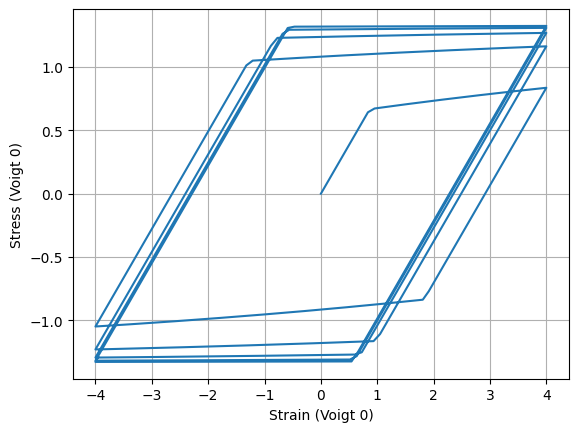

[0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [1]:
# full_dict_based_plasticity.py
from functools import partial
import jax
import jax.numpy as jnp
from jax import value_and_grad, jit, lax
from jax.flatten_util import ravel_pytree

import time

from jax import tree

import matplotlib.pyplot as plt

from jax import config
config.update("jax_enable_x64", True)

# ----------------- elastic stiffness (engineering Voigt) -----------------
# ---- keep your C_iso_voigt exactly like this (no extra text on lines) ----
def C_iso_voigt(E, nu):
    mu  = E / (2.0 * (1.0 + nu))
    lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    lam2 = lam + 2.0 * mu
    return jnp.array([
        [lam2, lam,  lam,  0., 0., 0.],
        [lam,  lam2, lam,  0., 0., 0.],
        [lam,  lam,  lam2, 0., 0., 0.],
        [0.,   0.,   0.,   mu, 0., 0.],
        [0.,   0.,   0.,   0., mu, 0.],
        [0.,   0.,   0.,   0., 0., mu],
    ])

# ----------------- small helpers (engineering-Voigt) -----------------
W = jnp.array([1., 1., 1., 2., 2., 2.])

def dev_voigt(sig):
    tr = sig[0] + sig[1] + sig[2]
    return sig.at[0:3].add(-tr / 3.0)

def norm_voigt(sig, eps=None):
    if eps is None:
        eps = jnp.asarray(1e-16, dtype=sig.dtype)
    return jnp.sqrt(jnp.dot(W * sig, sig) + eps)

#def df_dsigma_analytic(sigma):
#    s = dev_voigt(sigma)
#    n = norm_voigt(s)
#    g = dev_voigt(W * s) / n
#    return jnp.sqrt(3.0 / 2.0) * g

from jax.scipy.linalg import solve as la_solve

def newton(residual_fn, x0, dyn_args, tol=1e-8, abs_tol=1e-12, max_iter=100):
    tol     = jnp.asarray(tol,     dtype=x0.dtype)
    abs_tol = jnp.asarray(abs_tol, dtype=x0.dtype)

    def res(x): return residual_fn(x, *dyn_args)
    Jfun = jax.jacfwd(res)  # <- comme dans ta version qui converge

    R0   = res(x0)
    Rini = jnp.linalg.norm(R0)

    def cond(c):
        x, i = c
        nR = jnp.linalg.norm(res(x))
        done = (nR < tol * Rini) | (nR < abs_tol)
        return (i < max_iter) & (~done)

    def body(c):
        x, i = c
        R  = res(x)
        J  = Jfun(x)
        #dx = jnp.linalg.solve(J, R)
        dx = la_solve(J, R, assume_a='gen')  # un poil plus robuste
        return (x - dx, i + 1)

    x_fin, iters = lax.while_loop(cond, body, (x0, 0))
    Rend  = jnp.linalg.norm(res(x_fin))
    done  = (Rend < tol*Rini) | (Rend < abs_tol)
    iters = jnp.where(done, iters, -1)
    return x_fin, iters

# ----------------- dict/PyTree wrapper around array Newton -----------------
def newton_unravel(residual_fn_pytree, x0_tree, dyn_args, tol=1e-6, abs_tol=1e-8, max_iter=100):
    """
    residual_fn_pytree(x_tree, *dyn_args) -> residual_tree (same PyTree structure)
    x0_tree: PyTree (dicts, arrays…)
    Returns: (x_tree_solution, iters)
    """
    x0_flat, unravel_x = ravel_pytree(x0_tree)

    def res_flat(x_flat, *dyn):
        x_tree = unravel_x(x_flat)
        r_tree = residual_fn_pytree(x_tree, *dyn)
        r_flat, _ = ravel_pytree(r_tree)
        return r_flat

    x_fin_flat, iters = newton(res_flat, x0_flat, dyn_args, tol, abs_tol, max_iter)
    x_fin_tree = unravel_x(x_fin_flat)
    return x_fin_tree, iters

def R_iso(p, params):
    return params["Q"] * (1.0 - jnp.exp(-params["b"] * p))

def f_func(sigma, p, params):
    s = dev_voigt(sigma)
    return jnp.sqrt(3.0/2.0) * norm_voigt(s) - (params["sigma_y"] + R_iso(p, params))

#grad_f_wrt_sigma = jax.grad(lambda sigma, p, params: f_func(sigma, p, params), argnums=0)

# ----------------- constitutive residuals (dict in/out) -----------------
def residuals(x, epsilon, state_old, params):
    C = params["C"]
    sigma, eps_p, p, gamma = x["sigma"], x["eps_p"], x["p"], x["gamma"]
    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]

    sig_trial = C @ (epsilon - eps_p_old)
    f_trial   = f_func(sig_trial, p_old, params)

    # 1) relation élastique
    res_sigma = sigma - C @ (epsilon - eps_p)

    # 2) direction de flux par autodiff (comme “celui-là converge”)
    df_dsigma = jax.grad(lambda s: f_func(s, p, params))(sigma)
    # pas de projection supplémentaire ici (reste fidèle à la version qui marche)

    # 3) écoulement associé + cumul de plasticité
    res_epsp  = (eps_p - eps_p_old) - gamma * df_dsigma
    res_p     = (p - p_old) - gamma

    # 4) consistance plastique vs. γ=0 élastique
    res_gamma = f_func(sigma, p, params)

    return {"res_sigma": res_sigma, "res_epsp": res_epsp, "res_p": res_p, "res_gamma": res_gamma}

# ----------------- constitutive update (pure function) -----------------
def constitutive_update_fn(state_old, step_load, params,
                           tol=1e-8, abs_tol=1e-12, max_iter=100):
    C = params["C"]
    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]

    epsilon   = step_load["epsilon"]

    sigma_trial = C @ (epsilon - eps_p_old)
    f_trial     = f_func(sigma_trial, p_old, params)
    dtype       = sigma_trial.dtype

    it_dtype = jnp.int32  # <- unifie le dtype des itérations

    def elastic_branch(_):
        new_state = {"epsilon_p": eps_p_old, "p": p_old}
        fields    = {"sigma": sigma_trial}
        logs      = {"conv": jnp.asarray(0, dtype=it_dtype)}
        return new_state, fields, logs

    def plastic_branch(_):
        x0 = {
            "sigma": sigma_trial,
            "eps_p": eps_p_old,
            "p":     jnp.asarray(p_old, dtype=dtype),
            "gamma": jnp.asarray(0.0, dtype=dtype),
        }
        x_sol, iters = newton_unravel(
            residuals, x0, (epsilon, state_old, params),
            tol=tol, abs_tol=abs_tol, max_iter=max_iter
        )
        new_state = {"epsilon_p": x_sol["eps_p"], "p": x_sol["p"]}
        fields    = {"sigma": x_sol["sigma"]}
        logs      = {"conv": jnp.asarray(iters, dtype=it_dtype)}  # <- cast ici
        return new_state, fields, logs

    new_state, fields, logs = lax.cond(
        f_trial > 0.0,
        plastic_branch,
        elastic_branch,
        operand=None
    )
    return new_state, fields, logs

# ----------------- simulate (functional; takes state, load, params) -----------------
@partial(jax.jit, static_argnames=("update_fn",))
def simulate(update_fn, internal_state, load, params):
    def step(state, step_load):
        state, field, logs = update_fn(state, step_load, params)
        return state, (state, field, logs)

    state_T, (states_hist, fields_hist, logs_hist) = lax.scan(step, internal_state, load)
    saved = {"state": states_hist, "fields": fields_hist, "logs": logs_hist}
    return state_T, saved

def plot_stress_strain(saved, load, comp=0, effective=False, vs_time=False):
    # comp can be int or (sigma_idx, epsilon_idx)
    if isinstance(comp, (tuple, list)):
        s_idx, e_idx = int(comp[0]), int(comp[1])
    else:
        s_idx = e_idx = int(comp)

    # y: pick stress component
    y = jnp.asarray(saved["fields"]["sigma"][:, s_idx])

    # x: time or strain component (with optional effective injection)
    if vs_time:
        x = jnp.asarray(load["t"])
    else:
        eps = jnp.asarray(load["epsilon"])  # (T,6)

        if effective and "eps_cstr" in saved["fields"]:
            z_hist = jnp.asarray(saved["fields"]["eps_cstr"])        # (T,k)
            idxs   = jnp.asarray(load["sigma_cstr_idx"])              # (k,) or (T,k)

            if idxs.ndim == 1:
                eps = eps.at[:, idxs].set(z_hist)                     # constant indices
            else:
                # per-step indices
                def write_row(eps_row, z_row, idx_row):
                    return eps_row.at[idx_row].set(z_row)
                eps = jax.vmap(write_row)(eps, z_hist, idxs)

        x = eps[:, e_idx]

    plt.figure()
    plt.plot(x, y, linewidth=1.5)
    plt.xlabel("Time" if vs_time else fr"Strain (Voigt {e_idx})")
    plt.ylabel(fr"Stress (Voigt {s_idx})")
    plt.grid(True)
    plt.show()

# ----------------- example usage -----------------

# material params
E, nu = 1.0, 0.3
params = {
    "sigma_y": 1.0,
    "Q": 1.0,
    "b": jnp.array(0.1),
    "C": C_iso_voigt(E, nu),
}

# strain history
n_ts = 1000
ts = jnp.linspace(0., 1., n_ts)
eps_xx = 4.0 * jnp.sin(ts * 30.0)
epsilon_ts = (jnp.zeros((n_ts, 6))
              .at[:, 0].set(eps_xx)
              .at[:, 1].set(-0.5 * eps_xx)
              .at[:, 2].set(-0.5 * eps_xx))

load_list = [
    {"t": ts[i],
     "epsilon": epsilon_ts[i],
     }
    for i in range(len(ts))
]
def stack_load_list(load_list):
    # Turn list[dict(arrays)] -> dict(arrays with leading time dim)
    return jax.tree_util.tree_map(lambda *xs: jnp.stack(xs), *load_list)
load = stack_load_list(load_list)

# initial state
internal_state0 = {"epsilon_p": jnp.zeros(6), "p": jnp.array(0.0)}

# run
t0 = time.time()
state_T, saved = simulate(constitutive_update_fn,internal_state0, load, params)
jax.block_until_ready(saved)
print("simulate (first call):  %.2f ms" % ((time.time()-t0)*1e3))

# run
t0 = time.time()
state_T, saved = simulate(constitutive_update_fn,internal_state0, load, params)
jax.block_until_ready(saved)
print("simulate (already compiled):  %.2f ms" % ((time.time()-t0)*1e3))

# quick checks
print("Final p:", state_T["p"])
print("Hist sigma shape:", saved["fields"]["sigma"].shape)      # (T,6)
print("Hist eps_p shape:", saved["state"]["epsilon_p"].shape)  # (T,6)
print("Hist p shape:", saved["state"]["p"].shape)              # (T,)

plot_stress_strain(saved, load, comp=0)

print(saved["logs"]["conv"])

# Example 2: isotropic hardening with stress constraints

In [2]:
# ----------------- constitutive residuals (dict in/out) -----------------
def residuals(x, epsilon, state_old, params, sigma_idx):
    C = params["C"]
    sigma, eps_p, p, gamma = x["sigma"], x["eps_p"], x["p"], x["gamma"]
    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]

    # Contraintes : on remplace ε[eps_idx] par les inconnues eps_cstr
    epsilon_eff = epsilon.at[sigma_idx].set(x["eps_cstr"])

    # 1) relation élastique
    res_sigma = sigma - C @ (epsilon_eff - eps_p)

    # 2) direction de flux (autodiff) — plus de branchement ici
    df_dsigma = jax.grad(lambda s: f_func(s, p, params))(sigma)

    # 3) écoulement associé + cumul de plasticité
    res_epsp = (eps_p - eps_p_old) - gamma * df_dsigma
    res_p    = (p - p_old) - gamma

    # 4) contraintes sur sigma (σ[idx] = 0)
    res_cstr = sigma[sigma_idx]

    # 5) consistance plastique (Newton ne s'exécute que si on est en plastique)
    res_gamma = f_func(sigma, p, params)

    return {
        "res_sigma":  res_sigma,
        "res_epsp":   res_epsp,
        "res_p":      res_p,
        "res_gamma":  res_gamma,
        "res_cstr":   res_cstr,
    }

# ----------------- constitutive update (pure function) -----------------
def constitutive_update_fn(state_old, step_load, params,
                           tol=1e-8, abs_tol=1e-12, max_iter=100):
    C = params["C"]
    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]
    dtype = C.dtype

    epsilon   = step_load["epsilon"]
    sigma_idx = step_load.get("sigma_cstr_idx")

    # ---------- 1) Constrained elastic trial (γ=0, εp=εp_old) ----------
    # Solve for z = eps_cstr_trial so that (C @ (epsilon_eff - eps_p_old))[sigma_idx] = 0
    # A @ (z - epsilon[eps_idx]) = - r
    A = C[sigma_idx][:, sigma_idx]                                                   # (k,k)
    r = (C @ (epsilon - eps_p_old))[sigma_idx]                                     # (k,)
    dz = la_solve(A, r, assume_a='gen')                                            # (k,)
    z  = epsilon[sigma_idx] - dz                                                     # eps_cstr_trial
    epsilon_eff_trial = epsilon.at[sigma_idx].set(z)
    sigma_trial       = C @ (epsilon_eff_trial - eps_p_old)

    # yield function at trial
    f_trial = f_func(sigma_trial, p_old, params)

    it_dtype = jnp.int32  # keep cond branches identical

    # ---------- 2) Elastic branch (skip Newton) ----------
    def elastic_branch(_):
        new_state = {"epsilon_p": eps_p_old, "p": p_old}
        fields    = {"sigma": sigma_trial,
                     "eps_cstr": z}
        logs      = {"conv": jnp.asarray(0, dtype=it_dtype)}
        return new_state, fields, logs

    # ---------- 3) Plastic branch (run Newton), init with the constrained trial ----------
    def plastic_branch(_):
        x0 = {
            "sigma":    sigma_trial,
            "eps_p":    eps_p_old,
            "p":        jnp.asarray(p_old, dtype=dtype),
            "gamma":    jnp.asarray(0.0, dtype=dtype),
            "eps_cstr": jnp.asarray(z, dtype=dtype),  # good initial guess
        }
        x_sol, iters = newton_unravel(
            residuals, x0, (epsilon, state_old, params, sigma_idx),
            tol=tol, abs_tol=abs_tol, max_iter=max_iter
        )
        new_state = {"epsilon_p": x_sol["eps_p"], "p": x_sol["p"]}
        fields    = {"sigma": x_sol["sigma"],
                     "eps_cstr": x_sol["eps_cstr"]}
        logs      = {"conv": jnp.asarray(iters, dtype=it_dtype)}
        return new_state, fields, logs

    # ---------- 4) Gate on f_trial ----------
    new_state, fields, logs = lax.cond(
        f_trial > 0.0,
        plastic_branch,
        elastic_branch,
        operand=None
    )
    return new_state, fields, logs

simulate implicit (first):  4185.11 ms
simulate implicit (second):  58.80 ms
Final p: 41.9553899692757
Hist sigma shape: (1000, 6)
Hist eps_p shape: (1000, 6)
Hist p shape: (1000,)


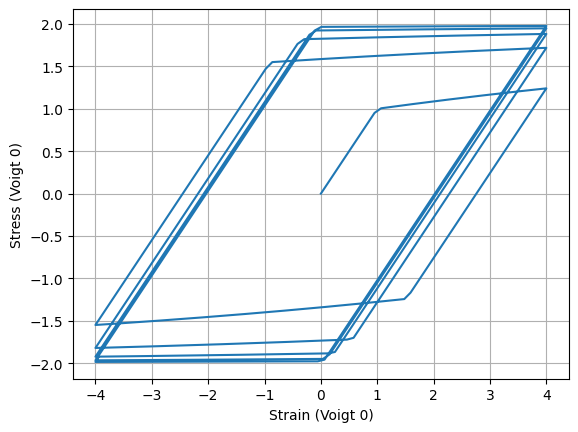

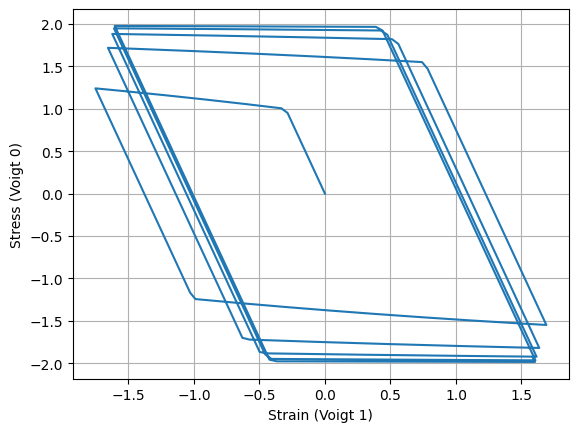

[0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [3]:
# ----------------- example usage -----------------

# material params
E, nu = 1.0, 0.3
params = {
    "sigma_y": 1.0,
    "Q": 1.0,
    "b": jnp.array(0.1),
    "C": C_iso_voigt(E, nu),
}

# strain history
n_ts = 1000
ts = jnp.linspace(0., 1., n_ts)
eps_xx = 4.0 * jnp.sin( ts * 30.0)
epsilon_ts = (jnp.zeros((n_ts, 6)).at[:, 0].set(eps_xx))

load_list = [
    {"t": ts[i],
     "epsilon": epsilon_ts[i],
     "sigma_cstr_idx": jnp.asarray([1, 2, 3, 4, 5])}
    for i in range(len(ts))
]
def stack_load_list(load_list):
    # Turn list[dict(arrays)] -> dict(arrays with leading time dim)
    return jax.tree_util.tree_map(lambda *xs: jnp.stack(xs), *load_list)
load = stack_load_list(load_list)

# initial state
internal_state0 = {"epsilon_p": jnp.zeros(6), "p": jnp.array(0.0)}

# run
t0 = time.time()
state_T, saved = simulate(constitutive_update_fn,internal_state0, load, params)
jax.block_until_ready(saved)
print("simulate implicit (first):  %.2f ms" % ((time.time()-t0)*1e3))

# run
t0 = time.time()
state_T, saved = simulate(constitutive_update_fn,internal_state0, load, params)
jax.block_until_ready(saved)
print("simulate implicit (second):  %.2f ms" % ((time.time()-t0)*1e3))

# quick checks
print("Final p:", state_T["p"])
print("Hist sigma shape:", saved["fields"]["sigma"].shape)      # (T,6)
print("Hist eps_p shape:", saved["state"]["epsilon_p"].shape)  # (T,6)
print("Hist p shape:", saved["state"]["p"].shape)              # (T,)

plot_stress_strain(saved, load, comp=[0,0])
plot_stress_strain(saved, load, comp=[0,1], effective=True)

print(saved["logs"]["conv"])

print(saved["fields"]["eps_cstr"][:10,:])

# Example 3: isotropic and kinematic hardening with stress constraints

In [4]:
# ----------------- constitutive residuals (dict in/out) -----------------
def residuals(x, epsilon, state_old, params, sigma_idx):
    C = params["C"]
    sigma, eps_p, p, gamma = x["sigma"], x["eps_p"], x["p"], x["gamma"]
    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]

    X = x["X"]
    X_old = state_old["X"]

    # Contraintes : on remplace ε[eps_idx] par les inconnues eps_cstr
    epsilon_eff = epsilon.at[sigma_idx].set(x["eps_cstr"])

    # 1) relation élastique
    res_sigma = sigma - C @ (epsilon_eff - eps_p)

    # 2) direction de flux (autodiff) — plus de branchement ici
    df_dsigma = jax.grad(lambda s: f_func(s-X, p, params))(sigma)

    # 3) écoulement associé + cumul de plasticité
    res_epsp = (eps_p - eps_p_old) - gamma * df_dsigma
    res_p    = (p - p_old) - gamma

    # 4) contraintes sur sigma (σ[idx] = 0)
    res_cstr = sigma[sigma_idx]

    # 5) consistance plastique (Newton ne s'exécute que si on est en plastique)
    res_gamma = f_func(sigma-X, p, params)

    res_X = (X - X_old) - ( 2./3. * params['C_kin'] * (eps_p-eps_p_old) - params['D_kin'] * X * (p-p_old) )

    return {
        "res_sigma":  res_sigma,
        "res_epsp":   res_epsp,
        "res_p":      res_p,
        "res_X":      res_X,
        "res_gamma":  res_gamma,
        "res_cstr":   res_cstr,
    }

# ----------------- constitutive update (pure function) -----------------
def constitutive_update_fn(state_old, step_load, params,
                           tol=1e-8, abs_tol=1e-12, max_iter=100):
    C = params["C"]
    eps_p_old, p_old, X_old = state_old["epsilon_p"], state_old["p"], state_old["X"]
    dtype = C.dtype

    epsilon   = step_load["epsilon"]
    sigma_idx = step_load.get("sigma_cstr_idx")

    # ---------- 1) Constrained elastic trial (γ=0, εp=εp_old) ----------
    # Solve for z = eps_cstr_trial so that (C @ (epsilon_eff - eps_p_old))[sigma_idx] = 0
    # A @ (z - epsilon[eps_idx]) = - r
    A = C[sigma_idx][:, sigma_idx]                                                   # (k,k)
    r = (C @ (epsilon - eps_p_old))[sigma_idx]                                     # (k,)
    dz = la_solve(A, r, assume_a='gen')                                            # (k,)
    z  = epsilon[sigma_idx] - dz                                                     # eps_cstr_trial
    epsilon_eff_trial = epsilon.at[sigma_idx].set(z)
    sigma_trial       = C @ (epsilon_eff_trial - eps_p_old)

    # yield function at trial
    f_trial = f_func(sigma_trial-X_old, p_old, params)

    it_dtype = jnp.int32  # keep cond branches identical

    # ---------- 2) Elastic branch (skip Newton) ----------
    def elastic_branch(_):
        new_state = {"epsilon_p": eps_p_old, "p": p_old, "X": X_old}
        fields    = {"sigma": sigma_trial}
        logs      = {"conv": jnp.asarray(0, dtype=it_dtype),
                     "eps_cstr": z}
        return new_state, fields, logs

    # ---------- 3) Plastic branch (run Newton), init with the constrained trial ----------
    def plastic_branch(_):
        x0 = {
            "sigma":    sigma_trial,
            "eps_p":    eps_p_old,
            "p":        jnp.asarray(p_old, dtype=dtype),
            "X":        jnp.asarray(X_old, dtype=dtype),
            "gamma":    jnp.asarray(0.0, dtype=dtype),
            "eps_cstr": jnp.asarray(z, dtype=dtype),  # good initial guess
        }
        x_sol, iters = newton_unravel(
            residuals, x0, (epsilon, state_old, params, sigma_idx),
            tol=tol, abs_tol=abs_tol, max_iter=max_iter
        )
        new_state = {"epsilon_p": x_sol["eps_p"], "p": x_sol["p"], "X": x_sol["X"]}
        fields    = {"sigma": x_sol["sigma"]}
        logs      = {"conv": jnp.asarray(iters, dtype=it_dtype),
                     "eps_cstr": x_sol["eps_cstr"]}
        return new_state, fields, logs

    # ---------- 4) Gate on f_trial ----------
    new_state, fields, logs = lax.cond(
        f_trial > 0.0,
        plastic_branch,
        elastic_branch,
        operand=None
    )
    return new_state, fields, logs

simulate implicit (first):  5777.80 ms
simulate implicit (second):  108.99 ms
Final p: 37.83555247416551
Hist sigma shape: (1000, 6)
Hist eps_p shape: (1000, 6)
Hist p shape: (1000,)


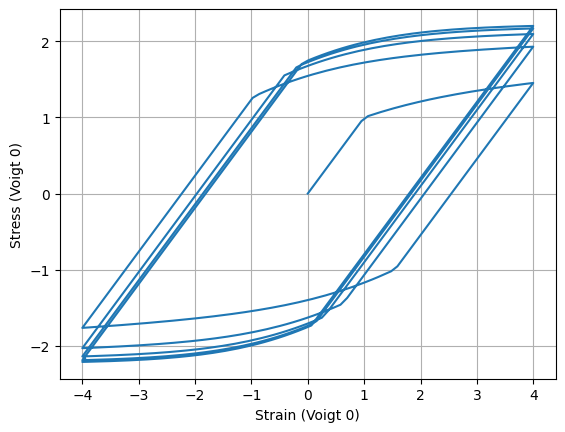

[0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [5]:
# ----------------- example usage -----------------

# material params
E, nu = 1.0, 0.3
params = {
    "sigma_y": 1.0,
    "Q": 1.0,
    "b": jnp.array(0.1),
    "C_kin": 0.25 ,
    "D_kin": 1.0 ,
    "C": C_iso_voigt(E, nu),
}

# strain history
n_ts = 1000
eps_xx = 4.0 * jnp.sin(jnp.linspace(0., 1., n_ts) * 30.0)
epsilon_ts = (jnp.zeros((n_ts, 6))
              .at[:, 0].set(eps_xx))

load_list = [
    {"t": ts[i],
     "epsilon": epsilon_ts[i],
     "sigma_cstr_idx": jnp.asarray([1, 2, 3, 4, 5])}
    for i in range(len(ts))
]
def stack_load_list(load_list):
    # Turn list[dict(arrays)] -> dict(arrays with leading time dim)
    return jax.tree_util.tree_map(lambda *xs: jnp.stack(xs), *load_list)
load = stack_load_list(load_list)

# initial state
internal_state0 = {"epsilon_p": jnp.zeros(6,), "p": jnp.array(0.0),"X": jnp.zeros(6,)}

# run
t0 = time.time()
state_T, saved = simulate(constitutive_update_fn,internal_state0, load, params)
jax.block_until_ready(saved)
print("simulate implicit (first):  %.2f ms" % ((time.time()-t0)*1e3))

# run
t0 = time.time()
state_T, saved = simulate(constitutive_update_fn,internal_state0, load, params)
jax.block_until_ready(saved)
print("simulate implicit (second):  %.2f ms" % ((time.time()-t0)*1e3))

# quick checks
print("Final p:", state_T["p"])
print("Hist sigma shape:", saved["fields"]["sigma"].shape)      # (T,6)
print("Hist eps_p shape:", saved["state"]["epsilon_p"].shape)  # (T,6)
print("Hist p shape:", saved["state"]["p"].shape)              # (T,)

plot_stress_strain(saved, load, comp=0)

print(saved["logs"]["conv"])

Tu as un grad à travers Newton qui passe par un lax.while_loop avec critère d’arrêt dynamique. En reverse-mode, JAX refuse ça → d’où:

Reverse-mode differentiation does not work for lax.while_loop … with dynamic start/stop values.

✅ Solution simple : réécrire Newton avec un nombre d’itérations fixe (via lax.scan ou fori_loop) et geler l’état une fois convergé, au lieu de casser la boucle. Ça garde des bornes statiques ⇒ OK pour l’autodiff/BFGS.

Colle ce patch (il remplace ton _newton + newton_jit). Rien d’autre à changer dans ton code d’identification.

In [6]:
import jax
import jax.numpy as jnp
from jax import jacfwd, lax
from functools import partial

import jax
import jax.numpy as jnp
from jax import jacfwd, vjp, lax
from functools import partial

import jax
import jax.numpy as jnp
from jax import jacfwd, vjp, lax
from functools import partial

# ------------------------------
# Fixed-scan Newton (forward)
# ------------------------------
import jax
import jax.numpy as jnp
from jax import jacfwd, vjp, lax
from functools import partial

# ------------------------------
# Fixed-scan Newton (forward)
# ------------------------------
def newton_fixed_scan(residual_fn, x0, dyn_args, tol=1e-8, abs_tol=1e-12, max_iter=10):
    x_dtype = getattr(x0, "dtype", jnp.float64)
    tol     = jnp.asarray(tol,     dtype=x_dtype)
    abs_tol = jnp.asarray(abs_tol, dtype=x_dtype)

    def res(x): return residual_fn(x, *dyn_args)
    Jfun = jacfwd(res)

    R0   = res(x0)
    Rini = jnp.linalg.norm(R0)

    def do_iter(x, iters):
        R  = res(x)
        J  = Jfun(x)
        dx = jnp.linalg.solve(J, R)
        x_cand = x - dx
        nR = jnp.linalg.norm(res(x_cand))
        conv_now = (nR < tol * Rini) | (nR < abs_tol)
        return x_cand, (iters + 1), conv_now

    def body(carry, _):
        x, iters, done = carry
        def keep(_): return x, iters, done
        def step(_):
            x1, it1, conv_now = do_iter(x, iters)
            done1  = done | conv_now
            x_next = jnp.where(done, x,  x1)
            it_next= jnp.where(done, iters, it1)
            return x_next, it_next, done1
        return lax.cond(done, keep, step, operand=None), None

    # length must be a concrete int
    (x_fin, iters, done_fin), _ = lax.scan(
        body, (x0, jnp.int32(0), jnp.array(False)), xs=None, length=int(max_iter)
    )
    iters = jnp.where(done_fin, iters, jnp.int32(-1))
    return x_fin, iters

# ---------------------------------------------
# Optional dynamic Newton (forward-only robust)
# ---------------------------------------------
def newton_while(residual_fn, x0, dyn_args, tol=1e-8, abs_tol=1e-12, max_iter=50):
    tol     = jnp.asarray(tol,     dtype=x0.dtype)
    abs_tol = jnp.asarray(abs_tol, dtype=x0.dtype)

    def res(x): return residual_fn(x, *dyn_args)
    Jfun = jacfwd(res)

    R0   = res(x0)
    Rini = jnp.linalg.norm(R0)

    def cond(carry):
        x, iters, done = carry
        return (~done) & (iters < max_iter)

    def body(carry):
        x, iters, done = carry
        R  = res(x)
        J  = Jfun(x)
        dx = jnp.linalg.solve(J, R)
        x1 = x - dx
        nR = jnp.linalg.norm(res(x1))
        done1 = (nR < tol * Rini) | (nR < abs_tol)
        return (x1, iters + 1, done1)

    x_fin, iters, done_fin = lax.while_loop(cond, body, (x0, jnp.int32(0), jnp.array(False)))
    iters = jnp.where(done_fin, iters, jnp.int32(-1))
    return x_fin, iters

# ----------------------------------------------------------
# Implicit-gradient Newton via custom VJP (IFT-based)
# nondiff_argnums: residual_fn, tol, abs_tol, max_iter are static
# ----------------------------------------------------------
@partial(jax.custom_vjp, nondiff_argnums=(0, 3, 4, 5))
def newton_implicit(residual_fn, x0, dyn_args, tol=1e-8, abs_tol=1e-12, max_iter=10):
    x_star, iters = newton_fixed_scan(residual_fn, x0, dyn_args, tol, abs_tol, max_iter)
    return x_star, iters

# FWD MUST KEEP THE SAME ORDER AS THE PRIMAL
def _newton_fwd(residual_fn, x0, dyn_args, tol=1e-8, abs_tol=1e-12, max_iter=10):
    x_star, iters = newton_fixed_scan(residual_fn, x0, dyn_args, tol, abs_tol, max_iter)
    aux = (x_star, dyn_args)  # stash what we need
    return (x_star, iters), aux

# BWD receives nondiff args first, then aux, ct; return grads for diff args only
def _newton_bwd(residual_fn, tol, abs_tol, max_iter, aux, ct):
    x_star, dyn_args = aux
    ct_x, _ct_iters = ct  # ignore integer cotangent

    def F_x(x):            # ∂F/∂x at solution
        return residual_fn(x, *dyn_args)

    def F_theta(*theta):   # ∂F/∂theta at solution
        return residual_fn(x_star, *theta)

    Jx  = jacfwd(F_x)(x_star)            # (n,n)
    lam = jnp.linalg.solve(Jx.T, ct_x)   # Jx^T λ = \bar{x}

    _, vjp_theta = vjp(F_theta, *dyn_args)
    grads_theta  = vjp_theta(-lam)       # -(∂F/∂theta)^T λ

    grad_x0 = jnp.zeros_like(x_star)     # no grad wrt initial guess (implicit)
    return grad_x0, grads_theta          # EXACTLY matches (x0, dyn_args)

# register VJP
newton_implicit.defvjp(_newton_fwd, _newton_bwd)

# Optional JIT wrapper (residual_fn static)
#newton_implicit_jit = jax.jit(newton_implicit, static_argnums=(0,))

# ----------------- dict/PyTree wrapper around array Newton -----------------
def newton_implicit_unravel(residual_fn_pytree, x0_tree, dyn_args, tol=1e-6, abs_tol=1e-8, max_iter=100):
    """
    residual_fn_pytree(x_tree, *dyn_args) -> residual_tree (same PyTree structure)
    x0_tree: PyTree (dicts, arrays…)
    Returns: (x_tree_solution, iters)
    """
    x0_flat, unravel_x = ravel_pytree(x0_tree)

    def res_flat(x_flat, *dyn):
        x_tree = unravel_x(x_flat)
        r_tree = residual_fn_pytree(x_tree, *dyn)
        r_flat, _ = ravel_pytree(r_tree)
        return r_flat

    x_fin_flat, iters = newton_implicit(res_flat, x0_flat, dyn_args, tol, abs_tol, max_iter)
    x_fin_tree = unravel_x(x_fin_flat)
    return x_fin_tree, iters

In [7]:
# ----------------- constitutive update (pure function) -----------------
def constitutive_update_fn(state_old, step_load, params,
                           tol=1e-8, abs_tol=1e-12, max_iter=100):
    C = params["C"]
    eps_p_old, p_old, X_old = state_old["epsilon_p"], state_old["p"], state_old["X"]
    dtype = C.dtype

    epsilon   = step_load["epsilon"]
    sigma_idx = step_load.get("sigma_cstr_idx")

    # ---------- 1) Constrained elastic trial (γ=0, εp=εp_old) ----------
    # Solve for z = eps_cstr_trial so that (C @ (epsilon_eff - eps_p_old))[sigma_idx] = 0
    # A @ (z - epsilon[eps_idx]) = - r
    A = C[sigma_idx][:, sigma_idx]                                                   # (k,k)
    r = (C @ (epsilon - eps_p_old))[sigma_idx]                                     # (k,)
    dz = la_solve(A, r, assume_a='gen')                                            # (k,)
    z  = epsilon[sigma_idx] - dz                                                     # eps_cstr_trial
    epsilon_eff_trial = epsilon.at[sigma_idx].set(z)
    sigma_trial       = C @ (epsilon_eff_trial - eps_p_old)

    # yield function at trial
    f_trial = f_func(sigma_trial-X_old, p_old, params)

    it_dtype = jnp.int32  # keep cond branches identical

    # ---------- 2) Elastic branch (skip Newton) ----------
    def elastic_branch(_):
        new_state = {"epsilon_p": eps_p_old, "p": p_old, "X": X_old}
        fields    = {"sigma": sigma_trial}
        logs      = {"conv": jnp.asarray(0, dtype=it_dtype),
                     "eps_cstr": z}
        return new_state, fields, logs

    # ---------- 3) Plastic branch (run Newton), init with the constrained trial ----------
    def plastic_branch(_):
        x0 = {
            "sigma":    sigma_trial,
            "eps_p":    eps_p_old,
            "p":        jnp.asarray(p_old, dtype=dtype),
            "X":        jnp.asarray(X_old, dtype=dtype),
            "gamma":    jnp.asarray(0.0, dtype=dtype),
            "eps_cstr": jnp.asarray(z, dtype=dtype),  # good initial guess
        }
        x_sol, iters = newton_implicit_unravel(
            residuals, x0, (epsilon, state_old, params, sigma_idx),
            tol=tol, abs_tol=abs_tol, max_iter=max_iter
        )
        new_state = {"epsilon_p": x_sol["eps_p"], "p": x_sol["p"], "X": x_sol["X"]}
        fields    = {"sigma": x_sol["sigma"]}
        logs      = {"conv": jnp.asarray(iters, dtype=it_dtype),
                     "eps_cstr": x_sol["eps_cstr"]}
        return new_state, fields, logs

    # ---------- 4) Gate on f_trial ----------
    new_state, fields, logs = lax.cond(
        f_trial > 0.0,
        plastic_branch,
        elastic_branch,
        operand=None
    )
    return new_state, fields, logs

simulate implicit (first):  2306.40 ms
simulate implicit (second):  378.53 ms
Final p: 37.83555247416551
Hist sigma shape: (1000, 6)
Hist eps_p shape: (1000, 6)
Hist p shape: (1000,)


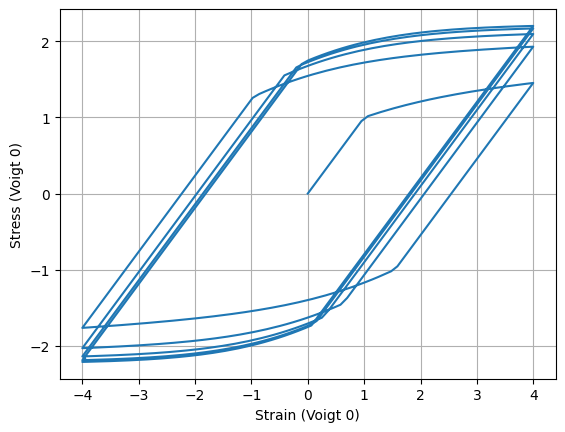

[0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [8]:
# ----------------- example usage -----------------

# material params
E, nu = 1.0, 0.3
params = {
    "sigma_y": 1.0,
    "Q": 1.0,
    "b": jnp.array(0.1),
    "C_kin": 0.25 ,
    "D_kin": 1.0 ,
    "C": C_iso_voigt(E, nu),
}

# strain history
n_ts = 1000
eps_xx = 4.0 * jnp.sin(jnp.linspace(0., 1., n_ts) * 30.0)
epsilon_ts = (jnp.zeros((n_ts, 6))
              .at[:, 0].set(eps_xx))

load_list = [
    {"t": ts[i],
     "epsilon": epsilon_ts[i],
     "sigma_cstr_idx": jnp.asarray([1, 2, 3, 4, 5])}
    for i in range(len(ts))
]
def stack_load_list(load_list):
    # Turn list[dict(arrays)] -> dict(arrays with leading time dim)
    return jax.tree_util.tree_map(lambda *xs: jnp.stack(xs), *load_list)
load = stack_load_list(load_list)


# initial state
internal_state0 = {"epsilon_p": jnp.zeros(6,), "p": jnp.array(0.0),"X": jnp.zeros(6,)}

# run
t0 = time.time()
state_T, saved = simulate(constitutive_update_fn,internal_state0, load, params)
jax.block_until_ready(saved)
print("simulate implicit (first):  %.2f ms" % ((time.time()-t0)*1e3))

# run
t0 = time.time()
state_T, saved = simulate(constitutive_update_fn,internal_state0, load, params)
jax.block_until_ready(saved)
print("simulate implicit (second):  %.2f ms" % ((time.time()-t0)*1e3))

# quick checks
print("Final p:", state_T["p"])
print("Hist sigma shape:", saved["fields"]["sigma"].shape)      # (T,6)
print("Hist eps_p shape:", saved["state"]["epsilon_p"].shape)  # (T,6)
print("Hist p shape:", saved["state"]["p"].shape)              # (T,)

plot_stress_strain(saved, load, comp=0)

print(saved["logs"]["conv"])

running Adam to initialize
[Adam]   loss = 3.005e-02
running BFGS for fine-tuning
[BFGS]   loss = 8.265e-15
Identified params: {'b': 0.10000010897438873, 'Q': 0.9999996617175814}


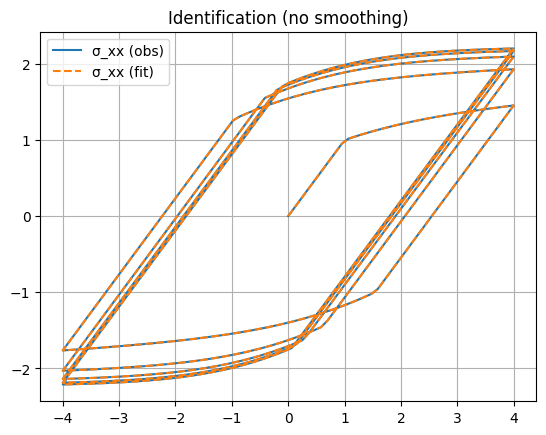

true_params {'sigma_y': 1.0, 'Q': 1.0, 'b': Array(0.1, dtype=float64, weak_type=True), 'C_kin': 0.25, 'D_kin': 1.0, 'C': Array([[1.34615385, 0.57692308, 0.57692308, 0.        , 0.        ,
        0.        ],
       [0.57692308, 1.34615385, 0.57692308, 0.        , 0.        ,
        0.        ],
       [0.57692308, 0.57692308, 1.34615385, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.38461538, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.38461538,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.38461538]], dtype=float64)}


In [13]:
from typing import NamedTuple


# ----------------- synthetic ex. + identification pipeline -----------------
true_params = params

# initial state (structure MUST stay identical through scan)
internal_state0 = {"epsilon_p": jnp.zeros(6), "p": jnp.array(0.0), "X": jnp.zeros(6)}

# generate synthetic observations
state_T, saved_true = simulate(constitutive_update_fn, internal_state0, load, true_params)
sigma_xx_obs = saved_true["fields"]["sigma"][:, 0]

# base params (to be partially identified later)
base_params = true_params

# ---- 1) Dict <-> flat vector (identity mapping) ----

def build_param_io_identity(init_phys: dict):
    theta0_vec, unravel = ravel_pytree({k: jnp.asarray(v, dtype=jnp.float64) for k, v in init_phys.items()})

    def pack(phys_dict):
        vec, _ = ravel_pytree({k: jnp.asarray(phys_dict[k], dtype=jnp.float64) for k in init_phys.keys()})
        return vec

    def unpack(theta_vec):
        d = unravel(theta_vec)
        return {k: jnp.asarray(d[k], dtype=jnp.float64) for k in init_phys.keys()}

    return pack, unpack, theta0_vec

# ---- 2) Loss on the flat vector (uses simulate correctly) ----

def make_loss_fn_identity(base_params: dict, epsilon_ts: jnp.ndarray, sigma_xx_obs: jnp.ndarray, unpack_fn):
    @jit
    def forward_sigma_xx_from_vec(theta_vec):
        learn_phys = unpack_fn(theta_vec)
        par = {**base_params, **learn_phys}
        # IMPORTANT: state structure consistent with constitutive_update_fn
        internal_state0 = {"epsilon_p": jnp.zeros(6,), "p": jnp.array(0.0), "X": jnp.zeros(6)}
        local_load = load
        _, saved = simulate(constitutive_update_fn, internal_state0, local_load, par)
        return saved["fields"]["sigma"][:, 0]

    @jit
    def loss(theta_vec):
        pred = forward_sigma_xx_from_vec(theta_vec)
        resid = pred - sigma_xx_obs
        return 0.5 * jnp.mean(resid**2)

    return loss

# ---- 3A) Pure-JAX Adam ----

class AdamState(NamedTuple):
    t: jnp.int32
    theta: jnp.ndarray
    m: jnp.ndarray
    v: jnp.ndarray
    best_theta: jnp.ndarray
    best_loss: jnp.ndarray


def adam_optimize(loss_fn, theta0, steps=400, lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8):
    loss_and_grad = jit(value_and_grad(loss_fn))

    def lr_schedule(t):
        t = jnp.asarray(t, dtype=jnp.float64)
        T = jnp.asarray(steps, dtype=jnp.float64)
        return lr * 0.5 * (1.0 + jnp.cos(jnp.pi * jnp.minimum(t, T) / T))

    f0, g0 = loss_and_grad(theta0)
    st0 = AdamState(
        t=jnp.int32(0),
        theta=theta0,
        m=jnp.zeros_like(theta0),
        v=jnp.zeros_like(theta0),
        best_theta=theta0,
        best_loss=f0,
    )

    def body(_, st: AdamState):
        t = st.t + 1
        f, g = loss_and_grad(st.theta)
        lr_t = lr_schedule(t)
        m = beta1 * st.m + (1 - beta1) * g
        v = beta2 * st.v + (1 - beta2) * (g * g)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        theta = st.theta - lr_t * m_hat / (jnp.sqrt(v_hat) + eps)
        better = f < st.best_loss
        best_theta = jnp.where(better, theta, st.best_theta)
        best_loss  = jnp.where(better, f, st.best_loss)
        return AdamState(t, theta, m, v, best_theta, best_loss)

    st_fin = lax.fori_loop(0, steps, body, st0)
    return st_fin.best_theta, float(st_fin.best_loss)

# ---- 3B) Pure-JAX BFGS ----

class BFGSState(NamedTuple):
    x: jnp.ndarray
    f: jnp.ndarray
    g: jnp.ndarray
    H: jnp.ndarray
    k: jnp.int32
    done: jnp.bool_

from jax import jit, lax, value_and_grad
import jax.numpy as jnp

from jax import jit, lax, value_and_grad
import jax.numpy as jnp

def bfgs_fulljax(loss_fn, theta0, max_iter=100, gtol=1e-7, c1=1e-4, c2=0.9):
    # c1 in (0, 1e-4], c2 in (c1, 1) – 0.9 works well in practice
    loss_and_grad = jit(value_and_grad(loss_fn))
    d = theta0.size
    I = jnp.eye(d, dtype=theta0.dtype)

    f0, g0 = loss_and_grad(theta0)
    st = BFGSState(theta0, f0, g0, I, jnp.int32(0), jnp.array(False))

    def strong_wolfe(x, f, g, p):
        # Backtracking + curvature check; few iterations to keep it light
        phi0   = f
        dphi0  = g @ p
        alpha0 = 1.0

        def cond(c):
            a, x_best, f_best, g_best, it = c
            return (it < 12) & ~(
                (f_best <= phi0 + c1 * a * dphi0) & (jnp.abs(g_best @ p) <= -c2 * dphi0)
            )

        def body(c):
            a, x_best, f_best, g_best, it = c
            x_try = x + a * p
            f_try, g_try = loss_and_grad(x_try)
            # Armijo ok and curvature ok?
            ok = (f_try <= phi0 + c1 * a * dphi0) & (jnp.abs(g_try @ p) <= -c2 * dphi0)
            # If Armijo fails, shrink alpha; if curvature fails, expand a bit (rare), else keep
            a_next = jnp.where(f_try > phi0 + c1 * a * dphi0, 0.5 * a, jnp.where((g_try @ p) > -c2 * dphi0, 1.5 * a, a))
            return (a_next, jnp.where(ok, x_try, x_best), jnp.where(ok, f_try, f_best), jnp.where(ok, g_try, g_best), it + 1)

        # init with alpha0 trial
        x1 = x + alpha0 * p
        f1, g1 = loss_and_grad(x1)
        carry0 = (alpha0, x1, f1, g1, 0)
        _, x_ok, f_ok, g_ok, _ = lax.while_loop(cond, body, carry0)
        return x_ok, f_ok, g_ok

    def one_iter(st: BFGSState):
        # Stop if already done
        done_now = st.done | (jnp.linalg.norm(st.g) < gtol)
        p = -st.H @ st.g

        # Strong Wolfe step
        x1, f1, g1 = strong_wolfe(st.x, st.f, st.g, p)

        s  = x1 - st.x
        y  = g1 - st.g
        ys = y @ s

        # Powell damping to ensure curvature (keeps H SPD)
        Hy   = st.H @ y
        sHs  = s @ (st.H @ s)
        theta = jnp.where(ys >= 0.2 * sHs, 1.0, (0.8 * sHs) / (sHs - ys + 1e-16))
        y_bar = theta * y + (1.0 - theta) * (st.H @ s)
        yb_s  = y_bar @ s

        def upd():
            rho = 1.0 / (yb_s + 1e-16)
            Hyb = st.H @ y_bar
            ybHy = y_bar @ Hyb
            # BFGS: H+ = H - (H ȳ sᵀ + s ȳᵀ H)/(ȳᵀ s) + (1 + ȳᵀ H ȳ / (ȳᵀ s)) * (s sᵀ)/(ȳᵀ s)
            return st.H - (jnp.outer(Hyb, s) + jnp.outer(s, Hyb)) * rho + ((1.0 + ybHy * rho) * rho) * jnp.outer(s, s)

        H1 = lax.cond(yb_s > 1e-14, lambda _: upd(), lambda _: st.H, operand=None)

        return BFGSState(
            x=jnp.where(done_now, st.x, x1),
            f=jnp.where(done_now, st.f, f1),
            g=jnp.where(done_now, st.g, g1),
            H=jnp.where(done_now, st.H, H1),
            k=st.k + 1,
            done=done_now,
        )

    st_fin = lax.fori_loop(0, max_iter, lambda _, s: one_iter(s), st)
    return st_fin.x, float(st_fin.f)

# ---- 4) Run identification (fit Q and b) ----

init_phys = {
    "b": jnp.array(0.04),   # initial guess
    "Q": jnp.array(0.5),    # initial guess
}

pack, unpack, theta0_vec = build_param_io_identity(init_phys)
loss_vec = make_loss_fn_identity(base_params, epsilon_ts, sigma_xx_obs, unpack)

# warm-up compilations
_ = loss_vec(theta0_vec)

theta_opt = theta0_vec

if 1:
    print('running Adam to initialize')
    theta_opt, f_adam = adam_optimize(loss_vec, theta0_vec, steps=50, lr=5e-3)
    print(f"[Adam]   loss = {f_adam:.3e}")

if 1:
    print('running BFGS for fine-tuning')
    theta_opt, f_bfgs = bfgs_fulljax(loss_vec, theta_opt, max_iter=50, gtol=1e-7)
    print(f"[BFGS]   loss = {f_bfgs:.3e}")

# Recover physical params as dict (identity mapping)
theta_phys = unpack(theta_opt)
print("Identified params:", {k: float(v) for k, v in theta_phys.items()})

# Optional: predicted curve (quick plot)

def forward_sigma_xx_from_phys(phys_dict):
    par = {**base_params, **phys_dict}
    state0 = {"epsilon_p": jnp.zeros(6), "p": jnp.array(0.0),"X": jnp.zeros(6)}
    _, saved_fit = simulate(constitutive_update_fn, state0, load, par)
    return saved_fit["fields"]["sigma"][:, 0]

sigma_fit = forward_sigma_xx_from_phys(theta_phys)

plt.figure()
plt.plot(epsilon_ts[:,0], sigma_xx_obs, label="σ_xx (obs)")
plt.plot(epsilon_ts[:,0], sigma_fit, "--", label="σ_xx (fit)")
plt.grid(True)
plt.legend()
plt.title("Identification (no smoothing)")
plt.show()

print("true_params",true_params)